# Heterokaryon Similarity Analysis

Simple analysis which sees how close the different single cells are to MRC5/3hr/16hr/48hr samples from the heterokaryon reprogramming system. The code is similar to (borrowed from) 20200210_scProgress.

In [1]:
library(ggrepel)
library(reshape2)
require(stringr)
library(SnapATAC)
library(GenomicRanges)
library(GenomicFeatures)
library(ggplot2)
library(DESeq2)
library(scales)

Loading required package: ggplot2

Loading required package: stringr

Loading required package: Matrix

Loading required package: rhdf5

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:SnapATAC’:

    colMeans, colSums, rowMeans, rowSums


The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, e

In [2]:
DAYS = c()
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"

file.list = c()
barcode.file.list = c()

for (i in seq(0, 14, 2)) {
    DAYS = c(DAYS, sprintf("D%d", i))
    file.list = c(file.list, sprintf("%s/D%d.snap", FILE_PREFIX, i))
}
DAYS
file.list

[1] "D0"  "D2"  "D4"  "D6"  "D8"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D8.snap" 
[6] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[8] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

In [3]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [4]:
# Metadata file from previous run
metaData = read.table("../20200122_snapATAC/snapATAC_sessions/20200125_n76770/metadata.tsv", header = T)
metaData$sample_barcode = paste(as.character(metaData$sample), as.character(metaData$barcode), sep='_')
metaData = metaData[order(metaData$sample_barcode), ]
head(metaData, 2)

barcode          cluster umap1    umap2    barcode.1        TN    UM   
1206 AAACAACGACGATTAC 6       2.515876 8.252824 AAACAACGACGATTAC 42629 38455
1207 AAACAACGACTCACGG 6       2.355841 7.403916 AAACAACGACTCACGG  4424  4009
     PP    UQ    CM landmark cluster.1 sample sample_barcode     
1206 38381 33575 51 0        6         D0     D0_AAACAACGACGATTAC
1207  3998  3694  4 0        6         D0     D0_AAACAACGACTCACGG

In [5]:
# Filter cells 
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% metaData[as.character(metaData$sample)==DAYS[i], "barcode"],];
})
names(x.sp.list) = DAYS;

In [6]:
x.sp.list

$D0
number of barcodes: 11133
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D2
number of barcodes: 9724
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D4
number of barcodes: 8726
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D6
number of barcodes: 10566
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D8
number of barcodes: 9895
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D10
number of barcodes: 4105
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D12
number of barcodes: 6334
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D14
number of barcodes: 16287
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0


In [7]:
# Using Peaks Matrix
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...



In [8]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

Warning message:
“'rBind' is deprecated.
 Since R version 3.2.0, base's rbind() should work fine with S4 objects”


In [9]:
x.sp

number of barcodes: 76770
number of bins: 0
number of genes: 0
number of peaks: 467339
number of motifs: 0

In [10]:
dim(x.sp@pmat)

[1]  76770 467339

In [11]:
rm(x.sp.list); # free memory
gc()

used       (Mb)   gc trigger (Mb)    max used   (Mb)   
Ncells   10651395  568.9   16227038   866.7   12513985   668.4
Vcells 1073155436 8187.6 3802464954 29010.6 3019984556 23040.7

In [12]:
x.sp = makeBinary(x.sp, mat="pmat");

In [13]:
# order by sample_barcode
x.sp = x.sp[order(paste(x.sp@sample, x.sp@barcode, sep='_')), ]

In [14]:
x.sp@cluster = factor(metaData$cluster)
slot(x.sp, "umap") = as.matrix(metaData[, c("umap1", "umap2")])

number of barcodes: 76770
number of bins: 0
number of genes: 0
number of peaks: 436310
number of motifs: 0

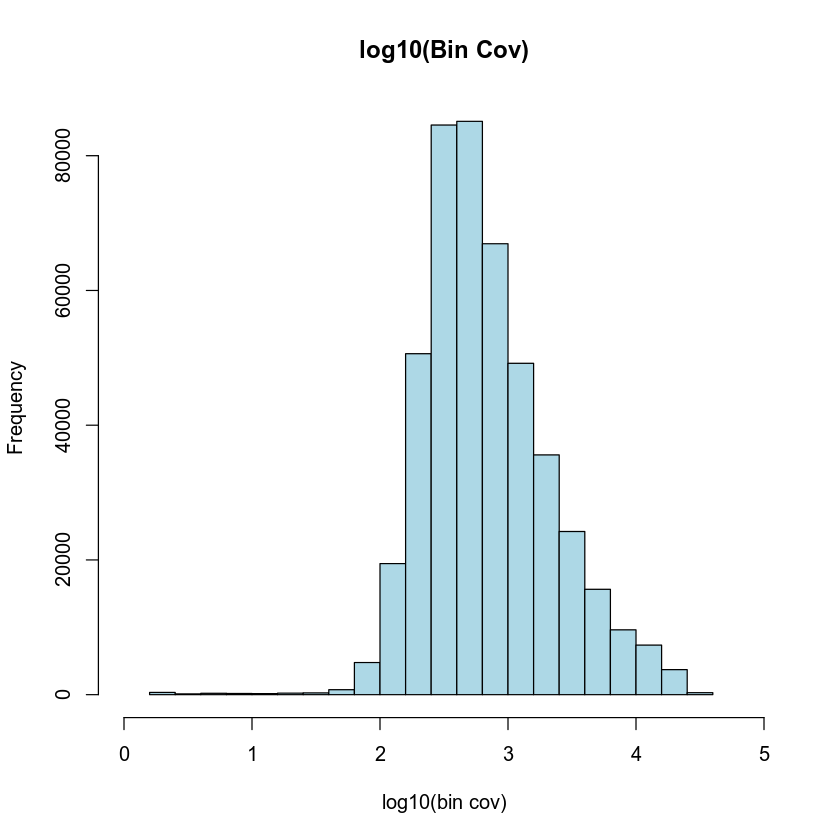

In [15]:
# remove all 0 bins and least variable ones
bin.cov = log10(Matrix::colSums(x.sp@pmat)+1);
hist(
  bin.cov[bin.cov > 0], 
  xlab="log10(bin cov)", 
  main="log10(Bin Cov)", 
  col="lightblue", 
  xlim=c(0, 5)
);
bin.cutoff = quantile(bin.cov[bin.cov > 0], 0.95);
idy = which(bin.cov <= bin.cutoff & bin.cov > 0);
x.sp = x.sp[, idy, mat="pmat"];
x.sp

## Load Reference Data

In [16]:
het.samples = c("het.MRC5.nodox.overlap",
               "het.3hr.nodox.overlap",
               "het.16hr.nodox.overlap",
               "het.48hr.nodox.overlap")

het_overlap_intersect_peaks = NULL

# load samples
for (sample in het.samples) {
    x <- read.csv(sprintf("./data/%s.bulk.cluster.overlap.intersect.txt", sample) ,sep="\t")
    rownames(x)=paste(x$chrom,x$start,x$end,sep='\t')
    x$chrom = NULL
    x$start = NULL
    x$end = NULL
    
    # binarize 
    x[,"count"] = ifelse(x[,"count"] > 0, 1, 0)
    colnames(x) = c(sample)
        
    if (is.null(het_overlap_intersect_peaks)) {
        het_overlap_intersect_peaks = x
    }
    else {
        het_overlap_intersect_peaks = data.frame(het_overlap_intersect_peaks, x)
    }
}

head(het_overlap_intersect_peaks)

het.MRC5.nodox.overlap het.3hr.nodox.overlap
chr1\t16147\t16347   0                      0                    
chr1\t51459\t51659   0                      0                    
chr1\t51689\t52109   0                      0                    
chr1\t180686\t181260 0                      0                    
chr1\t181268\t181597 0                      0                    
chr1\t184385\t184585 0                      0                    
                     het.16hr.nodox.overlap het.48hr.nodox.overlap
chr1\t16147\t16347   0                      0                     
chr1\t51459\t51659   0                      0                     
chr1\t51689\t52109   0                      0                     
chr1\t180686\t181260 0                      0                     
chr1\t181268\t181597 0                      0                     
chr1\t184385\t184585 0                      0

In [17]:
het_overlap_intersect_peaks = het_overlap_intersect_peaks[idy,]

In [18]:
# take only rows that have peaks specific to 1 or 2 samples
# If all peaks are taken then for all het timepoints the fibroblast
# like cells are always the most similar
specific_idy = which((rowSums(het_overlap_intersect_peaks)<3)&(rowSums(het_overlap_intersect_peaks)>0))
length(specific_idy)

[1] 84992

In [19]:
het_overlap_intersect_peaks_specific = het_overlap_intersect_peaks[specific_idy,]
x.sp.specific = x.sp[, specific_idy, mat="pmat"];

## Compute Jaccard Distances + Normalize

In [20]:
calJaccard <- function(X_i, X_j){
    A = Matrix::tcrossprod(X_i, X_j);
    bi = Matrix::rowSums(X_i);
    bj = Matrix::rowSums(X_j);
    jmat = as.matrix(A / (replicate(ncol(A), bi) + t(replicate(nrow(A), bj)) - A));
    rm(A);
    rm(bi);
    rm(bj);
    gc();
    return(jmat);
}

In [21]:
# fails with 1 row, use at least 2
x = matrix(t(het_overlap_intersect_peaks_specific), nrow=ncol(het_overlap_intersect_peaks_specific))

In [22]:
j = calJaccard(x.sp.specific@pmat, x)

In [23]:
p1 = Matrix::rowSums(x.sp.specific@pmat)/dim(x)[2]

In [24]:
probs = c()
for (i in seq(1,length(het.samples))) {
    probs = c(probs, sum(x[i,])/dim(x)[2])
}
probs

[1] 0.5503577 0.2831914 0.2585537 0.3244305

In [25]:
expected = list()
for (i in seq(1,length(het.samples))) {
    expected[[i]] = 1/((1/p1) + (1/probs[i]) - 1)
}

In [26]:
preds = list()
for (i in seq(1, length(het.samples))) {
    data = data.frame(x=unlist(expected[[i]]), y=c(j[,i]))
    model = lm(y ~ 0 + x + I(x^2), data)
    preds[[i]] = predict(model, data.frame(x=unlist(expected[[i]])))
}

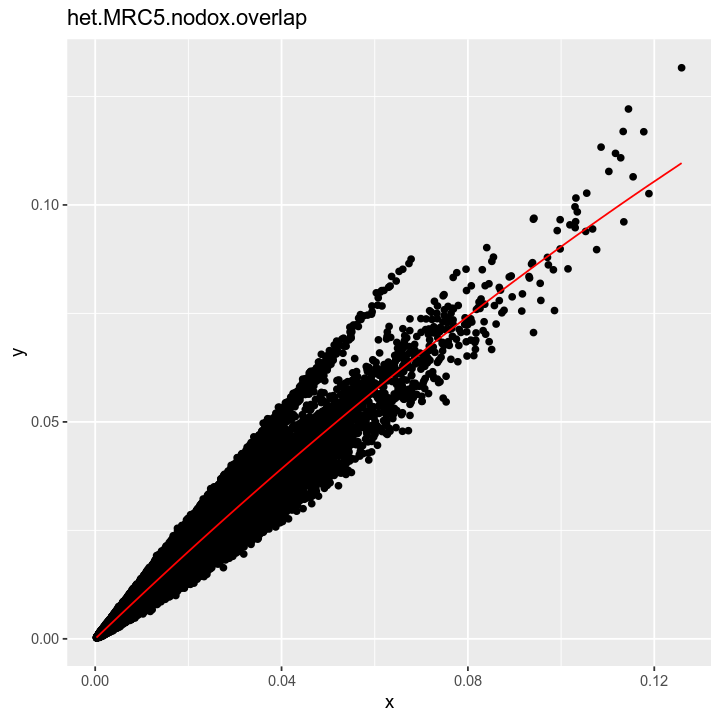

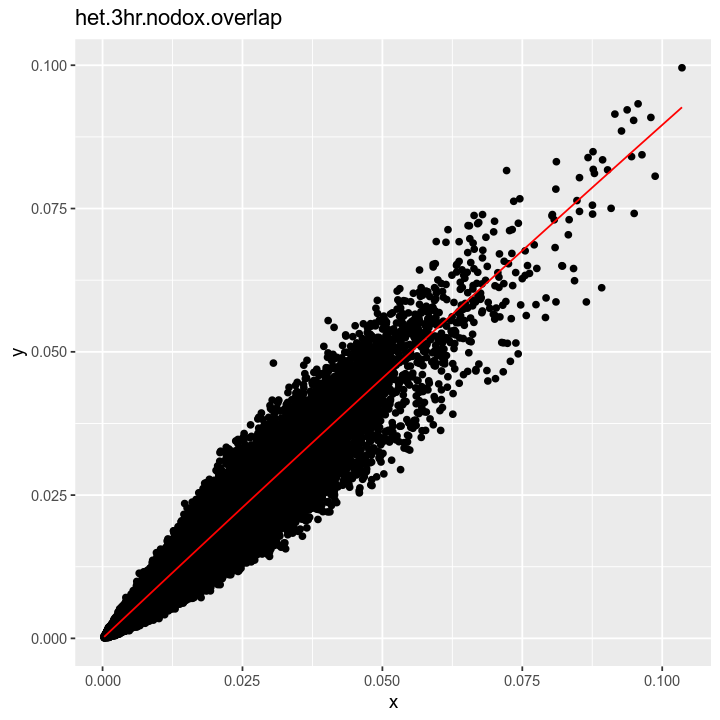

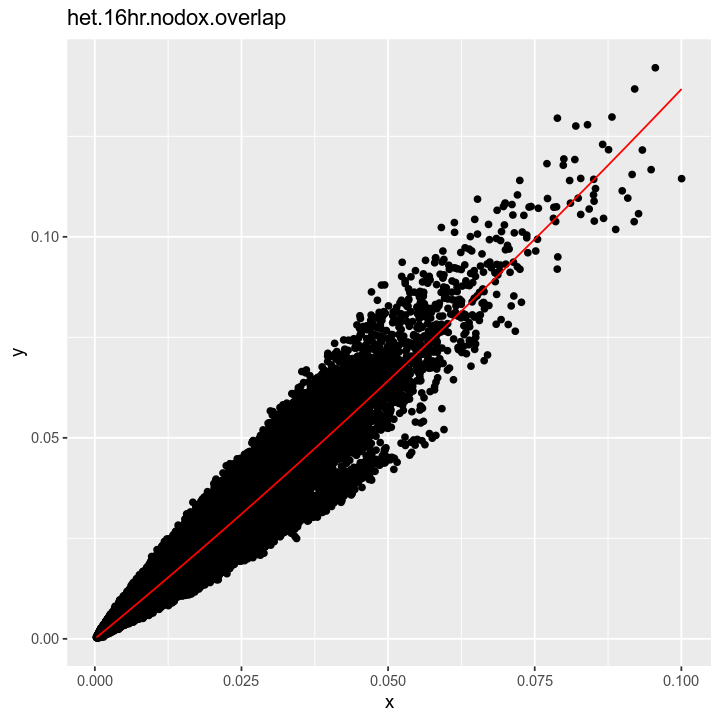

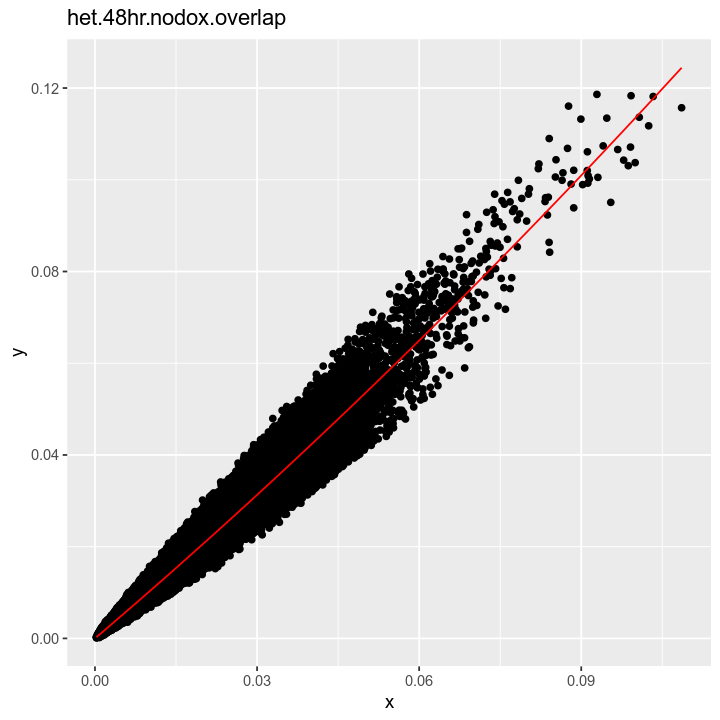

In [27]:
options(repr.plot.width = 6, repr.plot.height = 6)

for (i in seq(1, length(het.samples))) {
    p <- ggplot(data.frame(x=unlist(expected[[i]]), y=c(j[,i]), p=preds[[i]])) +
    geom_point(aes(x=x,y=y)) +
    geom_line(aes(x=x, y=p), color="red") +
    ggtitle(het.samples[[i]])
    
    print(p)
}

In [28]:
normalized = list()
for (i in seq(1, length(het.samples))) {
    normalized[[i]] = j[,i]/preds[[i]]
}

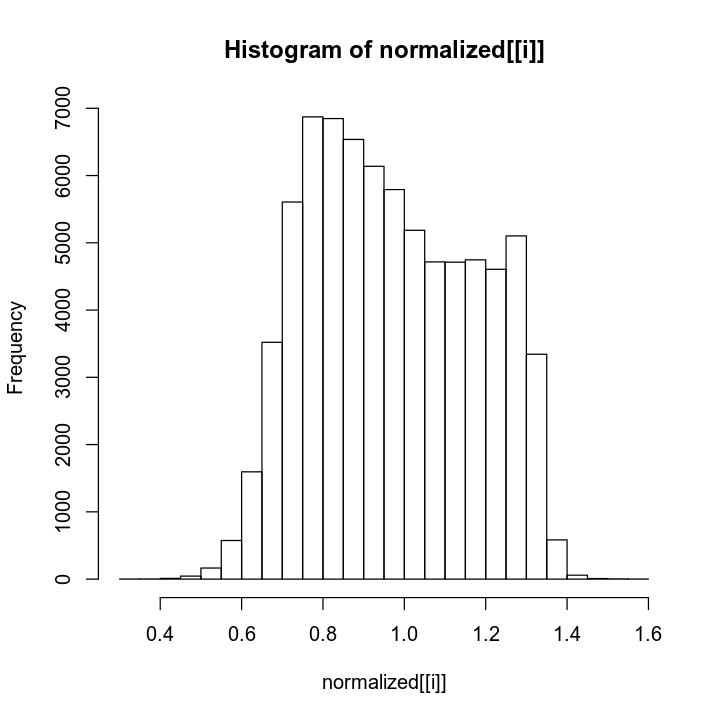

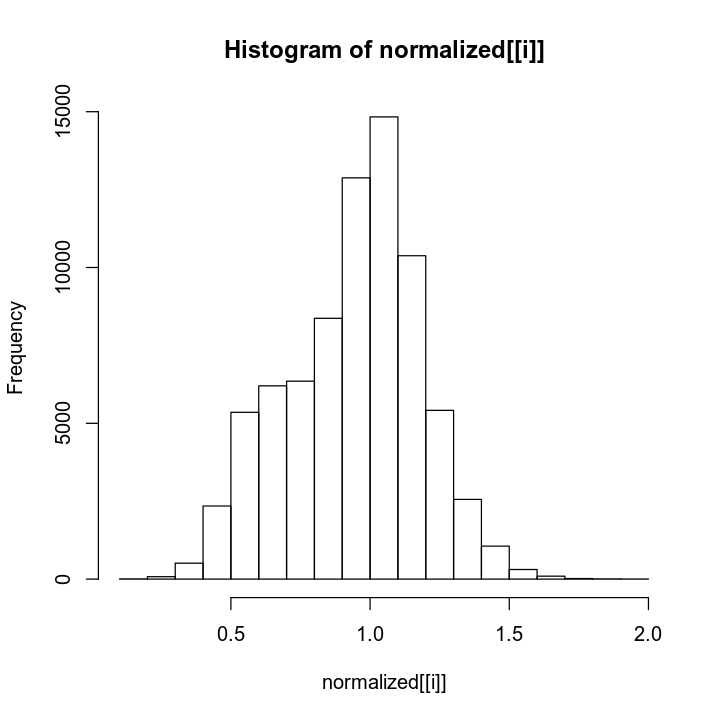

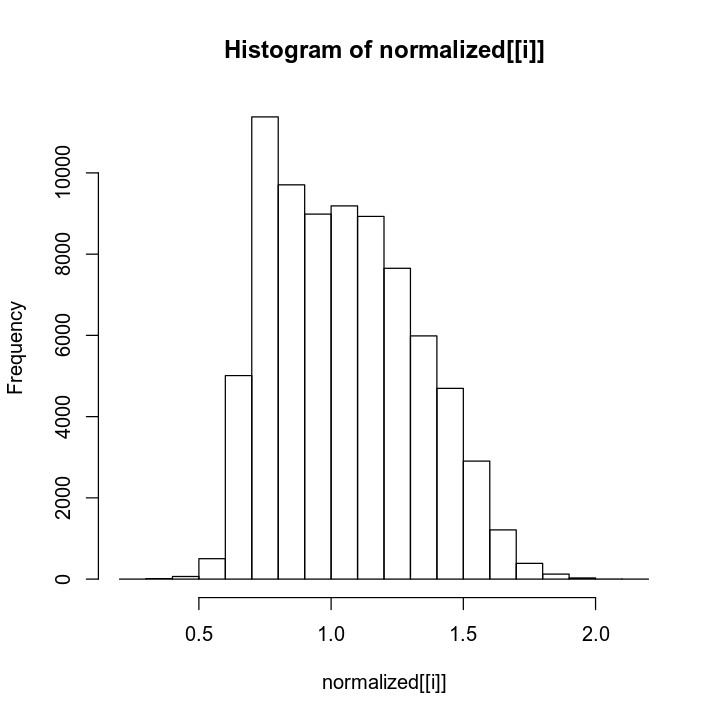

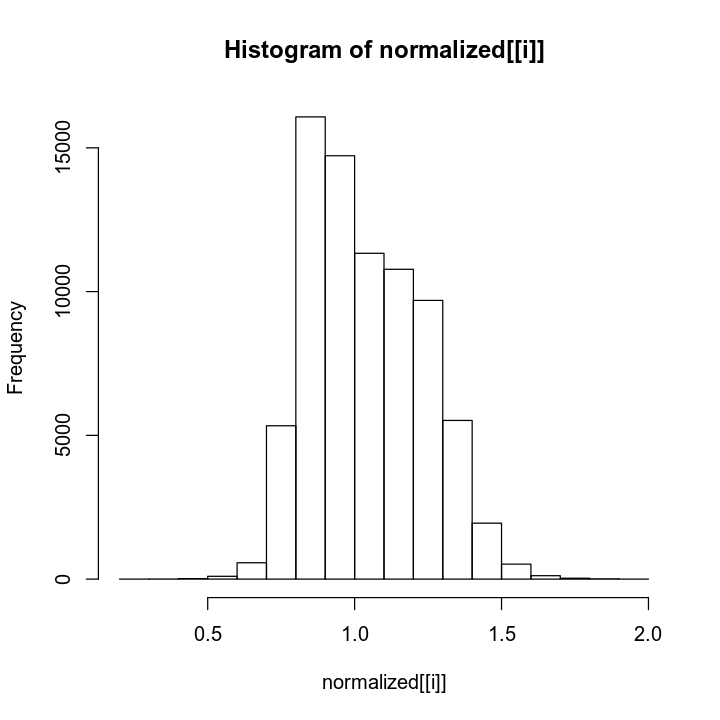

In [29]:
for (i in seq(1, length(het.samples))) {
    hist(normalized[[i]])
}

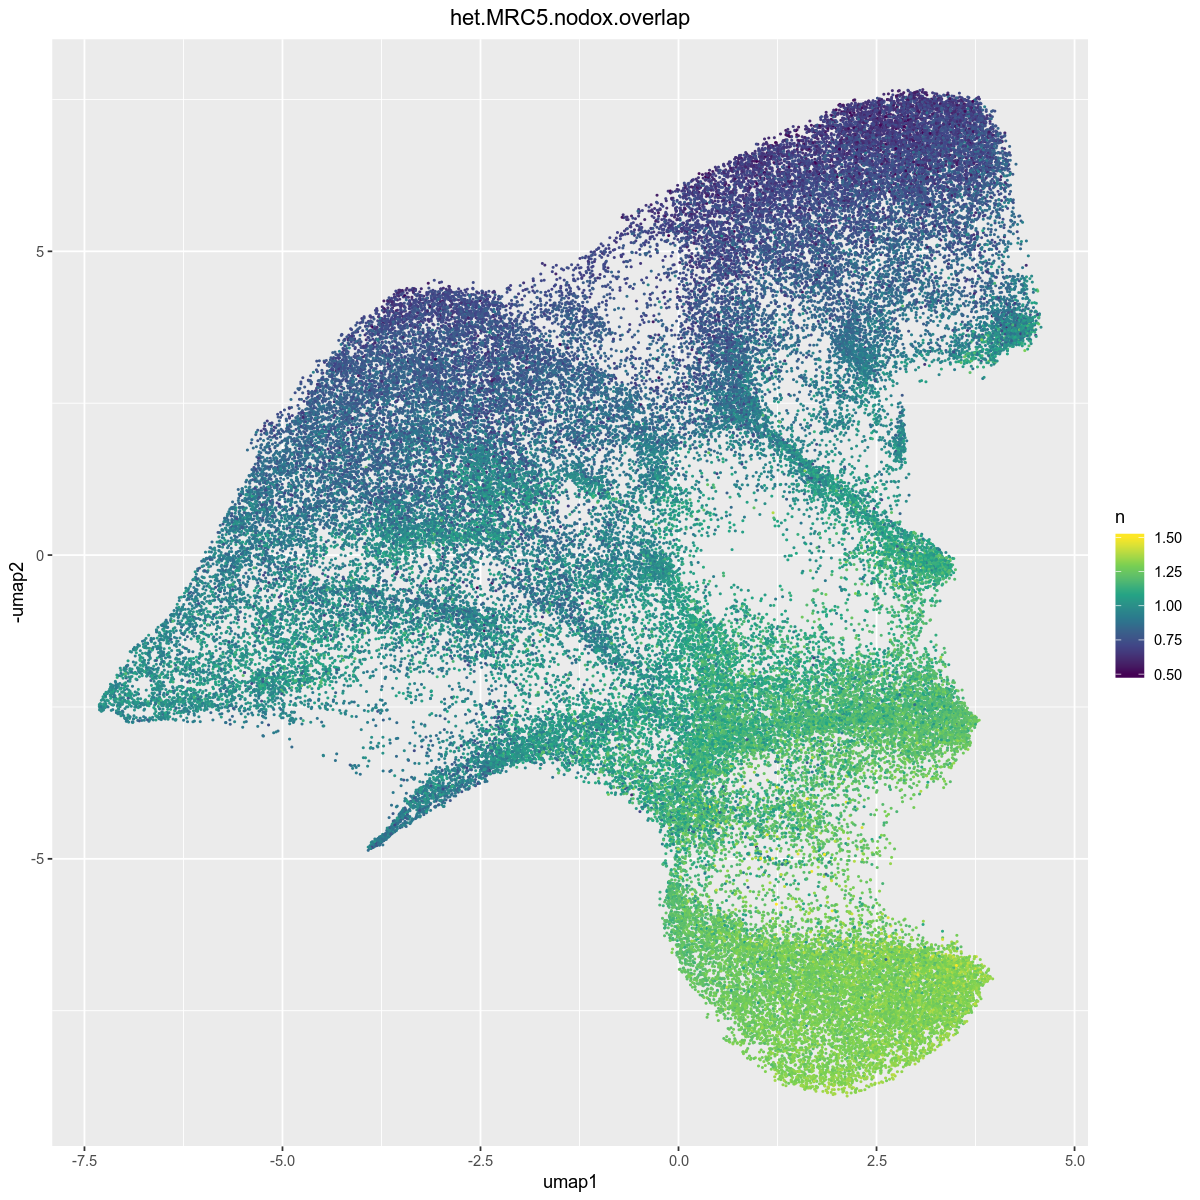

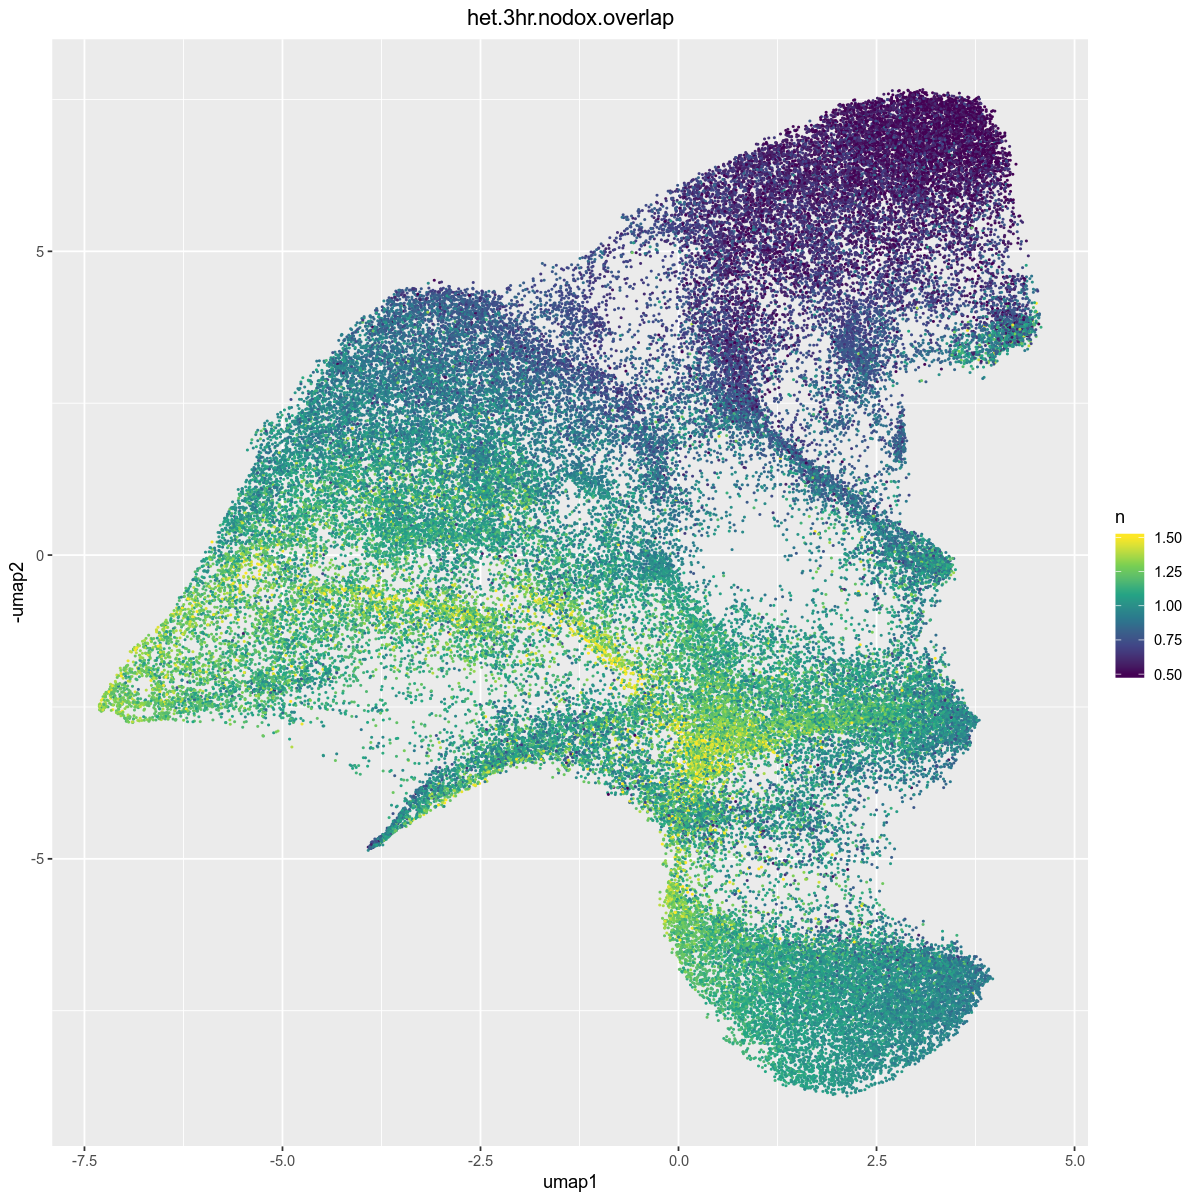

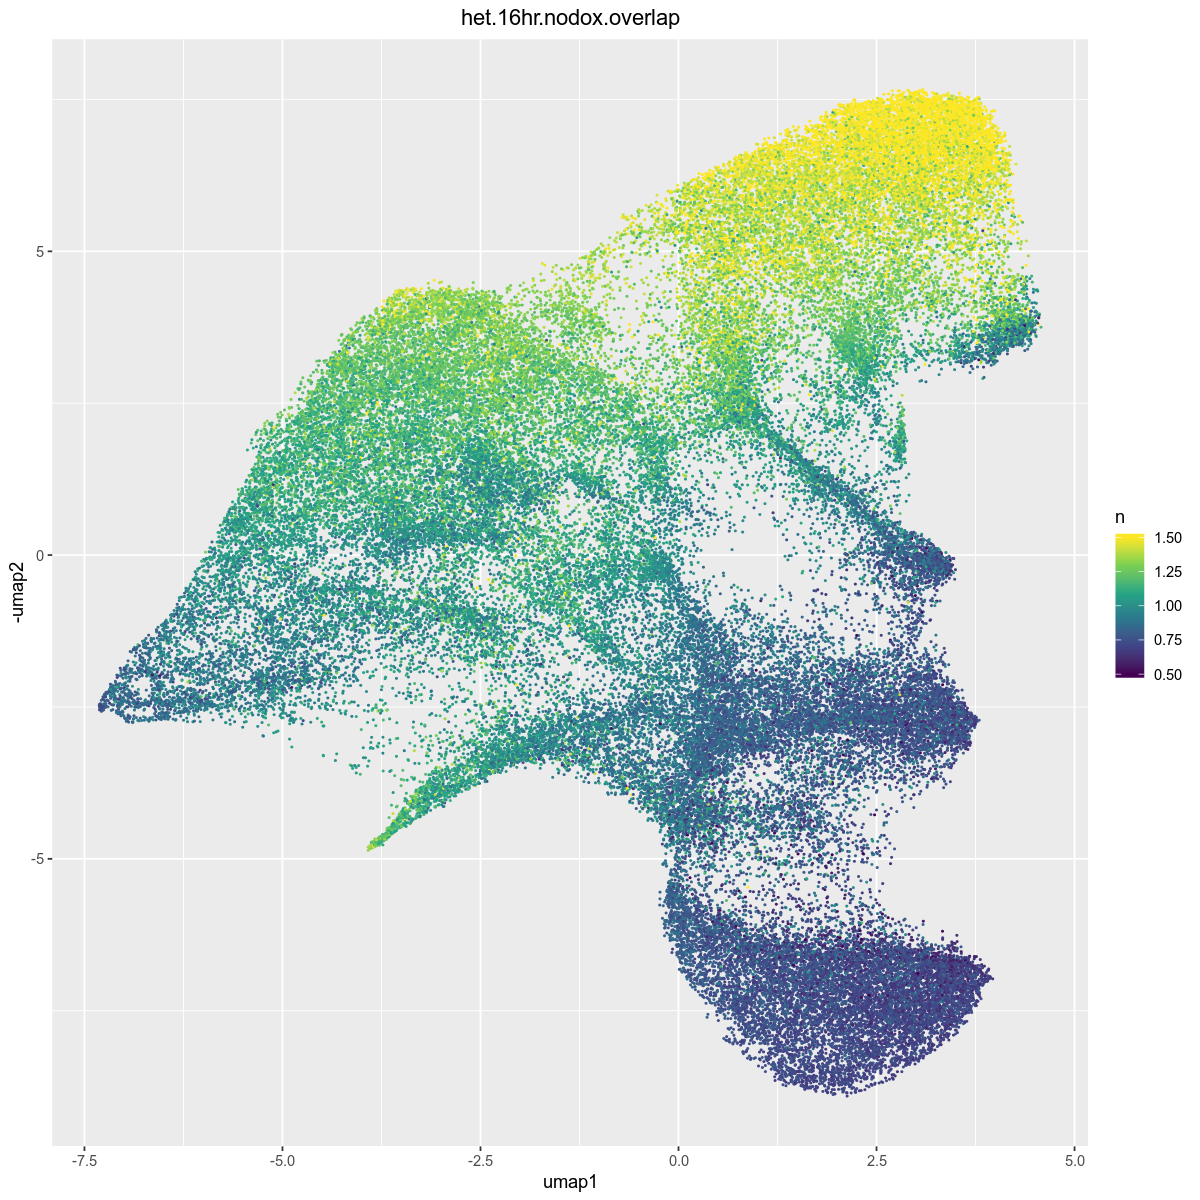

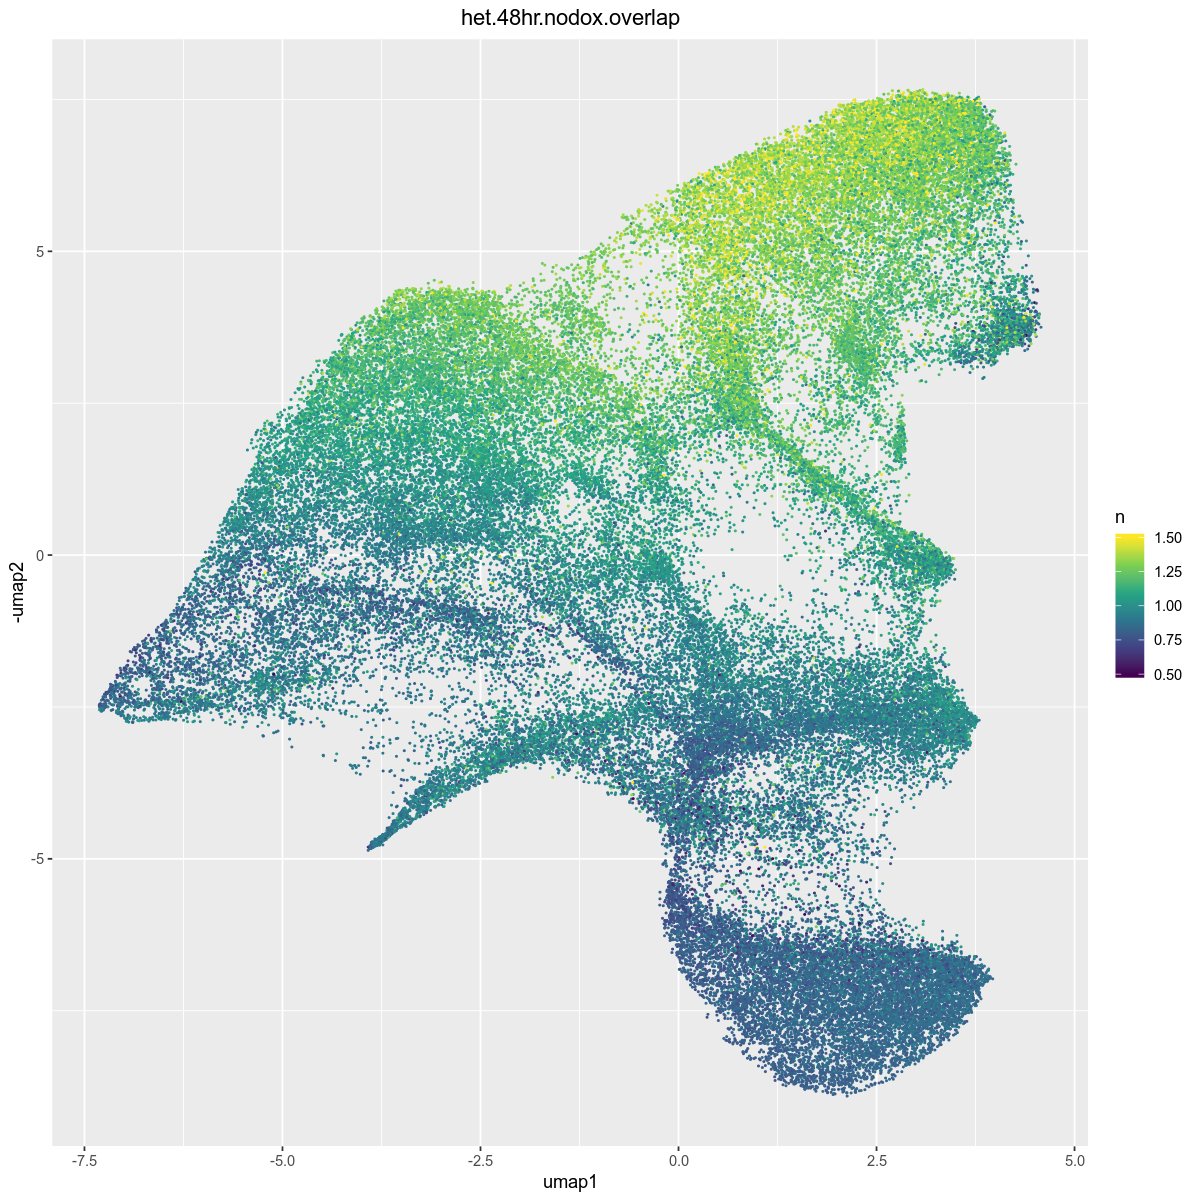

In [30]:
options(repr.plot.width = 10, repr.plot.height = 10)

for (i in seq(1, length(het.samples))) {
    df = data.frame(x.sp.specific@umap, x.sp.specific@sample, n=normalized[[i]])
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]
    
    p = ggplot(df) +
    geom_point(size=0.2, alpha=1, aes(x=umap1 , y=-umap2, col=n)) +
    scale_color_viridis_c(limit=c(0.5,1.5), oob = squish) +
    # scale_color_brewer(breaks=DAYS, palette = "Set1") +
    ggtitle("All Cells (Day)") + 
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle(het.samples[[i]])
    # guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
    # ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
    #                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))
    
    print(p)
}